# RNN for Time Series Prediction

This is a time series prediction task. You are given a dataset which reports on the weather and the level of pollution each hour for five years, and asked to train Recurrent Neural Networks (RNNs) to predict the hourly pollution level.

In [1]:
import numpy as np 
import pandas as pd 
import math
from datetime import datetime
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns 
from collections import Counter

from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

%matplotlib inline

D:\Applications\Python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## a) Load the data from the file. Perform necessary pre-processing (e.g., missing value replacement, uninformative attribute removal, etc.) and visualise the values of various attributes over the five-year period.

In [2]:
import os
import sys

# write your code here
DATA_DIR = './data/'
FILENAME = "pollution.csv"
FILE_PATH = os.path.abspath(os.path.join(DATA_DIR, FILENAME))
# print(FILE_PATH)

pollution_df = pd.read_csv(FILE_PATH, index_col="No")


In [3]:

HEAD_COUNT = 10

pollution_df.head(HEAD_COUNT)


,year,month,day,hour,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0


Over here, I have dropped the month, day and the hour. Converted the time information into a new variable called **datetime**. The information was dropped as it does not give us any insight into the pollution information. Intuitively, the pollution level is not dependent on time but rather on the weather conditions. 

It could be argued that the weather is dependent on time as the temperature and the dew point falls at night and is higher in the day. We'll look into this further later on in this document. 

In [4]:

pollution_df["datetime"] = pd.to_datetime(pollution_df[["year", "month", "day", "hour"]])

dt = pollution_df["datetime"]
pollution_df.drop("datetime", axis=1, inplace=True)

# pollution_df.drop("year", axis = 1, inplace=True)
pollution_df.drop("month", axis = 1, inplace=True)
pollution_df.drop("day", axis = 1, inplace=True)
pollution_df.drop("hour", axis = 1, inplace=True)

# pollution_df.insert(0, pollution_df.pop(pollution_df.index("datetime")))
pollution_df.insert(0, "datetime", dt)


In [5]:
pollution_df.head(HEAD_COUNT)

,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,
1,2010-01-01 00:00:00,2010,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010-01-01 01:00:00,2010,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010-01-01 02:00:00,2010,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010-01-01 03:00:00,2010,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010-01-01 04:00:00,2010,NaN,-20,-12.0,1018.0,NW,12.97,0,0
6,2010-01-01 05:00:00,2010,NaN,-19,-10.0,1017.0,NW,16.10,0,0
7,2010-01-01 06:00:00,2010,NaN,-19,-9.0,1017.0,NW,19.23,0,0
8,2010-01-01 07:00:00,2010,NaN,-19,-9.0,1017.0,NW,21.02,0,0
9,2010-01-01 08:00:00,2010,NaN,-19,-9.0,1017.0,NW,24.15,0,0


# Handling missing values

### Figuring out how many NaN values there are in the database. 

The empty values can either be dropped entirely, filled with 0's or filled with the mean. In this case, it will be filled with the mean values. 

There are **43824** records in total. Out of that, **2067** records are empty. For these records, they are filled by the mean of **pm2.5** values. 

In [6]:

total_pm25_nan = sum(pd.isnull(pollution_df["pm2.5"]))
percentage_nan = total_pm25_nan / len(pollution_df["pm2.5"]) * 100

print("Number of empty values: {}.\nPercentage of empty values: {:.2f}%".format(total_pm25_nan, percentage_nan))


Number of empty values: 2067.
Percentage of empty values: 4.72%


In [7]:

len(pollution_df["pm2.5"])


43824

Find out which columns has NaN values. With this, we can see that **pm2.5** is the only column with actual missing **NaN** values. 

In [8]:

pollution_df.isna().any()


datetime          False
year              False
pm2.5              True
Dew               False
Temperature       False
Pressure          False
Wind_Direction    False
Wind_Speed        False
Snow              False
Rain              False
dtype: bool

Fill out all missing **NaN** values with the mean.

In [9]:

empty_field_name = "pm2.5"

pollution_df[empty_field_name].fillna((pollution_df[empty_field_name].mean()), inplace=True)


In [10]:

pollution_df.head(HEAD_COUNT)


,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,
1,2010-01-01 00:00:00,2010,98.613215,-21,-11.0,1021.0,NW,1.79,0,0
2,2010-01-01 01:00:00,2010,98.613215,-21,-12.0,1020.0,NW,4.92,0,0
3,2010-01-01 02:00:00,2010,98.613215,-21,-11.0,1019.0,NW,6.71,0,0
4,2010-01-01 03:00:00,2010,98.613215,-21,-14.0,1019.0,NW,9.84,0,0
5,2010-01-01 04:00:00,2010,98.613215,-20,-12.0,1018.0,NW,12.97,0,0
6,2010-01-01 05:00:00,2010,98.613215,-19,-10.0,1017.0,NW,16.10,0,0
7,2010-01-01 06:00:00,2010,98.613215,-19,-9.0,1017.0,NW,19.23,0,0
8,2010-01-01 07:00:00,2010,98.613215,-19,-9.0,1017.0,NW,21.02,0,0
9,2010-01-01 08:00:00,2010,98.613215,-19,-9.0,1017.0,NW,24.15,0,0


In [11]:

pollution_df.tail(HEAD_COUNT)


,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Direction,Wind_Speed,Snow,Rain
No,,,,,,,,,,
43815,2014-12-31 14:00:00,2014,9.0,-27,1.0,1032.0,NW,196.21,0,0
43816,2014-12-31 15:00:00,2014,11.0,-26,1.0,1032.0,NW,205.15,0,0
43817,2014-12-31 16:00:00,2014,8.0,-23,0.0,1032.0,NW,214.09,0,0
43818,2014-12-31 17:00:00,2014,9.0,-22,-1.0,1033.0,NW,221.24,0,0
43819,2014-12-31 18:00:00,2014,10.0,-22,-2.0,1033.0,NW,226.16,0,0
43820,2014-12-31 19:00:00,2014,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43821,2014-12-31 20:00:00,2014,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43822,2014-12-31 21:00:00,2014,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43823,2014-12-31 22:00:00,2014,8.0,-22,-4.0,1034.0,NW,246.72,0,0


### Dropping Wind_Speed "cv" values

The wind speed attribute with values **cv** should be treated as noisy input or null values. As a result, all rows with **cv** values will be dropped.

We could have attempted to replace all these **cv** values with the **mode** of windirection but that would have increased the complexity of this task. As a result, it has been much easier to just drop the rows which has **cv** as the wind direction. 

In [12]:

index_of_wd_cv = pollution_df[pollution_df["Wind_Direction"] == "cv" ].index

pollution_df.drop(index_of_wd_cv , inplace=True)


# One hot encode wind direction

As the wind direction given is textual, we cannot use it to feed into the classifier. There are two / four options here:

- Label encoding

- Ordinal encoding

- One-hot encoding

- Dummy encoding

I have chosen dummy encoding in this instance one-hot and dummy encoding is statisically much better to deal with than label encoding. As a lot of the values here are continuous, label encoding is not statiscally good to use in this instance. As dummy encoding is much discreet, in this instance, its better to stick to dummy and one-hot. I have used dummy encoding as it's very easy to do in pandas. 

In [13]:

pollution_dummies = pd.get_dummies(pollution_df["Wind_Direction"])

pollution_df_dummy = pollution_df.drop("Wind_Direction", axis=1)
pollution_df_dummy = pollution_df_dummy.join(pollution_dummies)

pollution_df = pollution_df_dummy

pollution_df.head(HEAD_COUNT)


,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
No,,,,,,,,,,,,
1,2010-01-01 00:00:00,2010,98.613215,-21,-11.0,1021.0,1.79,0,0,0,1,0
2,2010-01-01 01:00:00,2010,98.613215,-21,-12.0,1020.0,4.92,0,0,0,1,0
3,2010-01-01 02:00:00,2010,98.613215,-21,-11.0,1019.0,6.71,0,0,0,1,0
4,2010-01-01 03:00:00,2010,98.613215,-21,-14.0,1019.0,9.84,0,0,0,1,0
5,2010-01-01 04:00:00,2010,98.613215,-20,-12.0,1018.0,12.97,0,0,0,1,0
6,2010-01-01 05:00:00,2010,98.613215,-19,-10.0,1017.0,16.10,0,0,0,1,0
7,2010-01-01 06:00:00,2010,98.613215,-19,-9.0,1017.0,19.23,0,0,0,1,0
8,2010-01-01 07:00:00,2010,98.613215,-19,-9.0,1017.0,21.02,0,0,0,1,0
9,2010-01-01 08:00:00,2010,98.613215,-19,-9.0,1017.0,24.15,0,0,0,1,0


# Plots

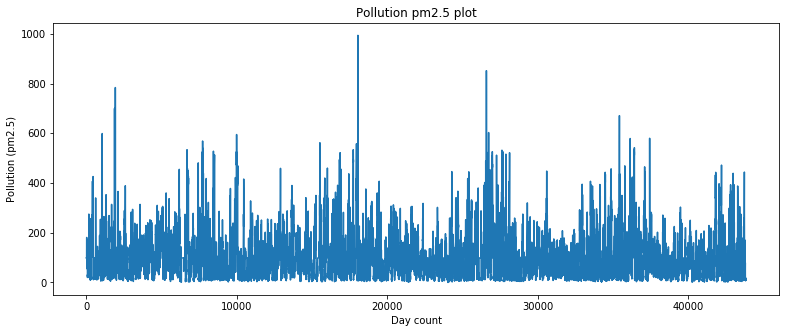

In [14]:

FIGURE_SIZE = (13, 5)

# Pollution plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["pm2.5"])
plt.xlabel('Day count')
plt.ylabel('Pollution (pm2.5)')
plt.title('Pollution pm2.5 plot')

plt.show()


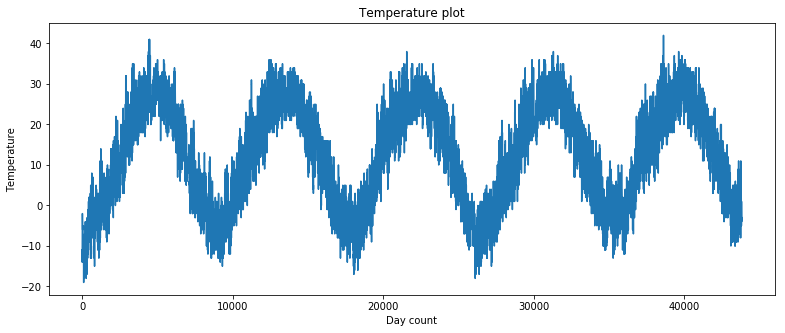

In [15]:

# Temperature plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Temperature"])
plt.xlabel('Day count')
plt.ylabel('Temperature')
plt.title('Temperature plot')

plt.show()


Over here, we can see that the **dew** and the **temperature** is very highly correlated by just looking at the two plots visually. 

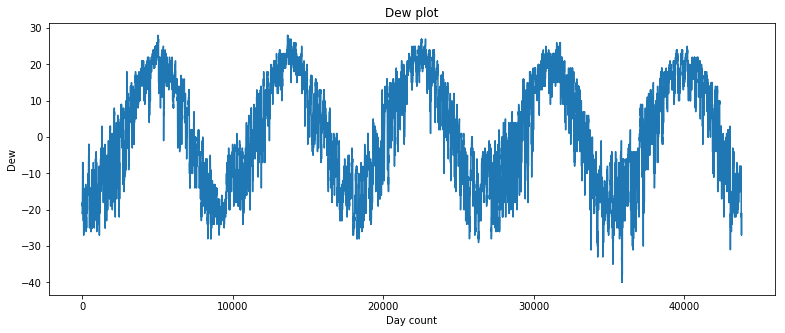

In [16]:

# Dew plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Dew"])
plt.xlabel('Day count')
plt.ylabel('Dew')
plt.title('Dew plot')

plt.show()


We can see that there are much higher windspeed spikes when the temperature is low. When the temperature is high, the wind speed tends to be much higher. 

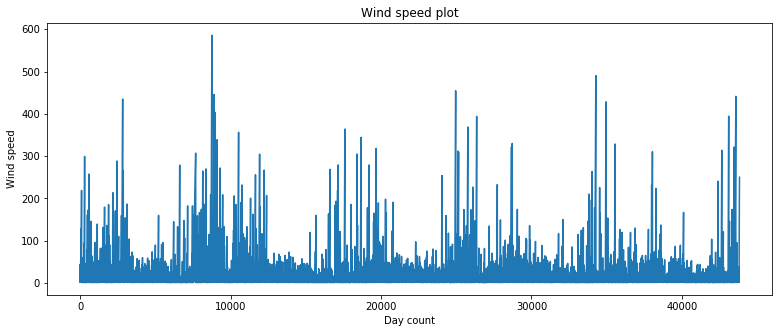

In [17]:

# Wind speed plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Wind_Speed"])
plt.xlabel('Day count')
plt.ylabel('Wind speed')
plt.title('Wind speed plot')

plt.show()


Its very clear visually that the pressure plot is **inversely-correlated** to the temperature and the dew plots. When the temperature is low, the pressue is high and vice versa. 

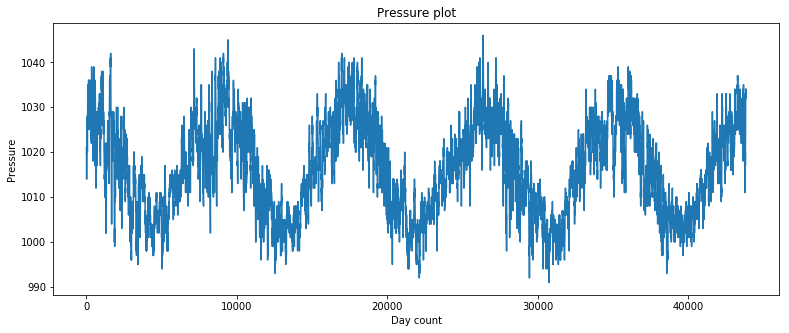

In [18]:

# Pressure plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Pressure"])
plt.xlabel('Day count')
plt.ylabel('Pressure')
plt.title('Pressure plot')

plt.show()


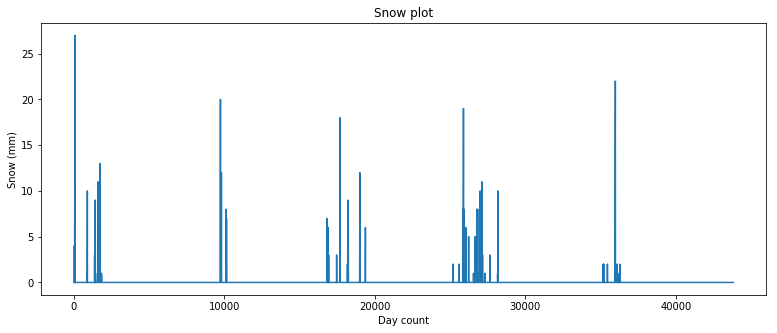

In [19]:

# Snow plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Snow"])
plt.xlabel('Day count')
plt.ylabel('Snow (mm)')
plt.title('Snow plot')

plt.show()


There is a higher amount of both rain and snow during high-pressure systems when the temperature is lower.

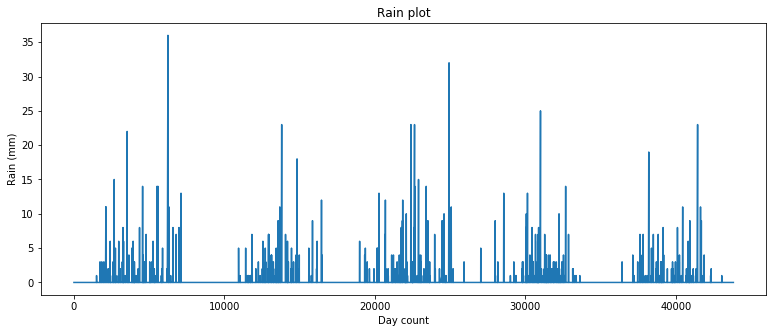

In [20]:

# Rain plot
plt.figure(figsize=FIGURE_SIZE)
plt.plot(pollution_df.index.values, pollution_df["Rain"])
plt.xlabel('Day count')
plt.ylabel('Rain (mm)')
plt.title('Rain plot')

plt.show()


In [21]:

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression


D:\Applications\Python3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### b) Frame the task as the supervised learning problem as predicting the pollution at the current hour given the pollution measurement and weather conditions at the previous hour. Using the first 4 years' data as the training set and the remaining 1 year's data as the test set. Prepare the training/test sets accordingly.

In [22]:
from sklearn import preprocessing

# write your code here

pollution_df.head(HEAD_COUNT)

p_train_index = pollution_df[pollution_df["year"] < 2014].index
p_test_index = pollution_df[pollution_df["year"] == 2014].index

p_train = pollution_df.drop(p_test_index)
p_test = pollution_df.drop(p_train_index)


In [23]:
p_train.head(HEAD_COUNT)

,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
No,,,,,,,,,,,,
1,2010-01-01 00:00:00,2010,98.613215,-21,-11.0,1021.0,1.79,0,0,0,1,0
2,2010-01-01 01:00:00,2010,98.613215,-21,-12.0,1020.0,4.92,0,0,0,1,0
3,2010-01-01 02:00:00,2010,98.613215,-21,-11.0,1019.0,6.71,0,0,0,1,0
4,2010-01-01 03:00:00,2010,98.613215,-21,-14.0,1019.0,9.84,0,0,0,1,0
5,2010-01-01 04:00:00,2010,98.613215,-20,-12.0,1018.0,12.97,0,0,0,1,0
6,2010-01-01 05:00:00,2010,98.613215,-19,-10.0,1017.0,16.10,0,0,0,1,0
7,2010-01-01 06:00:00,2010,98.613215,-19,-9.0,1017.0,19.23,0,0,0,1,0
8,2010-01-01 07:00:00,2010,98.613215,-19,-9.0,1017.0,21.02,0,0,0,1,0
9,2010-01-01 08:00:00,2010,98.613215,-19,-9.0,1017.0,24.15,0,0,0,1,0


In [24]:
p_test.head(HEAD_COUNT)

,datetime,year,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
No,,,,,,,,,,,,
35065,2014-01-01 00:00:00,2014,24.0,-20,7.0,1014.0,143.48,0,0,0,1,0
35066,2014-01-01 01:00:00,2014,53.0,-20,7.0,1013.0,147.50,0,0,0,1,0
35067,2014-01-01 02:00:00,2014,65.0,-20,6.0,1013.0,151.52,0,0,0,1,0
35068,2014-01-01 03:00:00,2014,70.0,-20,6.0,1013.0,153.31,0,0,0,1,0
35070,2014-01-01 05:00:00,2014,92.0,-18,4.0,1012.0,4.02,0,0,0,1,0
35071,2014-01-01 06:00:00,2014,106.0,-19,6.0,1012.0,8.94,0,0,0,1,0
35072,2014-01-01 07:00:00,2014,75.0,-19,6.0,1013.0,16.09,0,0,0,1,0
35073,2014-01-01 08:00:00,2014,58.0,-18,6.0,1013.0,21.90,0,0,0,1,0
35074,2014-01-01 09:00:00,2014,33.0,-18,7.0,1014.0,26.82,0,0,0,1,0


The heads of the train and test dataset is printed to ensure the split has happened correctly. **2010** to **2013** for train and **2014** for test. 

**Train set: p_train**<br>
**Test set: p_test**

In [25]:

x_train_p = p_train.drop(columns=["datetime", "year"])
x_test_p = p_test.drop(columns=["datetime", "year"])


### Scaling all the columns 

Scaling is applied to both the **x_train** and **x_test** to make **x_train_scaled** and **x_test_scaled**. 

For this, I have used two different scalers. One scaler is for the while dataframe and the other one is just for a dataframe with just the **pm2.5** value. The second scaler is created to allow for the inverse-transform of the scaled results to the actual values in the final step of the process so that the RMSE can be calculated. 

As there are significantly scaling difference in things like the temperature versus the pressure, the training is much faster and better when their values are scaled to a much more suitable amount. 

In [26]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

x_train_test_total = x_train_p.append(x_test_p)

scaler = StandardScaler().fit(x_train_test_total)
pm25_scaler = StandardScaler().fit(x_train_test_total["pm2.5"])

x_train_scaled = pd.DataFrame(scaler.transform(x_train_p), columns=x_train_p.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test_p), columns=x_test_p.columns)


D:\Applications\Python3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [27]:
x_train_scaled.head(HEAD_COUNT)

,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
0,0.083099,-1.502890,-1.896999,0.423379,-0.510659,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
1,0.083099,-1.502890,-1.977796,0.327938,-0.453626,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
2,0.083099,-1.502890,-1.896999,0.232497,-0.421010,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
3,0.083099,-1.502890,-2.139389,0.232497,-0.363977,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
4,0.083099,-1.434991,-1.977796,0.137056,-0.306945,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
5,0.083099,-1.367093,-1.816203,0.041615,-0.249912,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
6,0.083099,-1.367093,-1.735406,0.041615,-0.192879,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
7,0.083099,-1.367093,-1.735406,0.041615,-0.160263,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
8,0.083099,-1.367093,-1.735406,0.041615,-0.103231,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
9,0.083099,-1.434991,-1.654610,0.041615,-0.046198,-0.073355,-0.140993,-0.411989,1.197376,-0.893621


In [28]:
x_test_scaled.head(HEAD_COUNT)

,pm2.5,Dew,Temperature,Pressure,Wind_Speed,Snow,Rain,NE,NW,SE
0,-0.783787,-1.434991,-0.442662,-0.244708,2.071115,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
1,-0.446853,-1.434991,-0.442662,-0.340149,2.144365,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
2,-0.307432,-1.434991,-0.523459,-0.340149,2.217614,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
3,-0.249340,-1.434991,-0.523459,-0.340149,2.250231,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
4,0.006264,-1.299194,-0.685052,-0.435590,-0.470025,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
5,0.168922,-1.367093,-0.523459,-0.435590,-0.380376,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
6,-0.191249,-1.367093,-0.523459,-0.340149,-0.250094,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
7,-0.388761,-1.299194,-0.523459,-0.340149,-0.144229,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
8,-0.679221,-1.299194,-0.442662,-0.244708,-0.054580,-0.073355,-0.140993,-0.411989,1.197376,-0.893621
9,-0.470090,-1.299194,-0.361866,-0.149267,0.035069,-0.073355,-0.140993,-0.411989,1.197376,-0.893621


In [29]:
# Sanity check to make sure their length is correct
print("train length: {}".format(len(x_train_scaled)))
print("test length: {}".format(len(x_test_scaled)))

train length: 27756
test length: 6681


In [30]:

y_train = pd.DataFrame(x_train_scaled["pm2.5"].shift(periods=-1))
y_test = pd.DataFrame(x_test_scaled["pm2.5"].shift(periods=-1))


#### Preparing the training data 

The prepation step involes shifting the **pm2.5** by -1 which moves up the value of pm2.5 by one compared to the result of the weather and previous pm2.5 data. 

Removing the last element of all the train and test sets as it's NaN for the pm2.5 and this will cause errorneous input

In [31]:

x_train_scaled = x_train_scaled[:-1]
x_test_scaled = x_test_scaled[:-1]

y_train = y_train[:-1]
y_test = y_test[:-1]


In [32]:

x_train = x_train_scaled.values
x_test = x_test_scaled.values

y_train = y_train.values
y_test = y_test.values


In [33]:
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.1

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = VAL_SIZE, random_state=200)

# train_val_set = x_train_scaled
# train_val_set["y"] = y_train

# test_set = x_test_scaled
# test_set["y"] = y_test




In [34]:

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))



### c) Train a Recurrent Neural Network (RNN) on the training set. You can split the training set further by using 10% of the data as the validation set and the remaining for training.


#### Architecture

As this is a regression task with RNNs, I have used one RNN Layer with LSTM cell with 400 neurons. The data has been reshaped in the previous note which allows for one time step. This is required for all inputs going into LSTM cells as it shows the number of timesteps being used. 

The two-layer neural network is a Dense Layer without any activation function. This has only one neuron as there is only one single output. This output is the **scaled** predicted value. To see the actual value, this needs to be **inverse-transformed**. 

The loss function is **mean-squared-error** which measures the distance from the actual value to the predicted value. 

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout

FIGURE_SIZE = (13, 4)

BATCH_SIZE = 512
EPOCHS = 200

# write your code here
# design network
model = Sequential()

model.add(LSTM(400, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=2, shuffle=False)


Train on 24979 samples, validate on 2776 samples
Epoch 1/200


InternalError: Blas GEMM launch failed : a.shape=(512, 10), b.shape=(10, 400), m=512, n=400, k=10
	 [[Node: lstm_1/while/MatMul_3 = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/lstm_1/while/MatMul_3_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_1/while/TensorArrayReadV3, lstm_1/while/MatMul_3/Enter)]]
	 [[Node: loss/mul/_81 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1678_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

The plot below shows the training and the test losses 

#### Loss plot

This is the whole loss plot. The loss drops significantly at the start and then stays fairly stable.

The second plot is the plot of the same data but with the first 10 epochs omitted. As the loss drops so quickly in the first 10 epochs, the scaling is much better to look at in the second one.

We can see that the training loss decreases overtime but the validation loss fluctuates a little without much improvement.

In [ ]:
# plot history
plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'][10:], label='train')
plt.plot(history.history['val_loss'][10:], label='test')
plt.legend()
plt.show()

### d) Output the prediction results such as Root Mean Squared Errors (RMSE) on the test set. Remember that after the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with other models. Plot the predicted values vs. the actual values.

In [ ]:
from sklearn.metrics import mean_squared_error

# write your code here


In [ ]:

def predict_and_score(_model, x, y):
    # Make predictions on the original scale of the data.
    y_hat = _model.predict(x)
    
    pred = pm25_scaler.inverse_transform(y_hat)
    y_inv_scaled = pm25_scaler.inverse_transform(y)
    
    x_actual_inv_scaled = scaler.inverse_transform(x)
    x_actual_inv_scaled = x_actual_inv_scaled.T[0].T
  
    score = math.sqrt(mean_squared_error(y_inv_scaled, pred))
    
    return(score, pred, x_actual_inv_scaled)


### Results

The RMSE shows the standard deviation of the actual values from the predicted results. THis means that the rmse value is that much likely to be deviated from the actual results. 

In [ ]:

rmse_train, train_predict, train_actual = predict_and_score(model, x_train, y_train)
rmse_test, test_predict, test_actual = predict_and_score(model, x_test, y_test)


In [ ]:
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))

In [ ]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_actual, label='actual')
plt.plot(train_predict, label='predicted')

plt.legend()
plt.show()


#### Train vs Actual plot

The graph below is the scatter plot between the train and the predicted values of the pollution. This is fairly straight with very few outliers meaning it's quie good. 

In the best case scenario without any errors, all the plots should be on a straight line of the equation of **y = x**. We can see from the plot that it's not the case. There is a bit of variance on the line and it's gradient is not **1**. However, its fairly close and tightly knit together. This shows a good result. 

In [ ]:


plt.figure(figsize=FIGURE_SIZE)
plt.scatter(train_actual,train_predict,  label='actual')
# plt.plot(label='predicted')

plt.legend()
plt.show()



In [ ]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_predict, label='predicted')
plt.plot(train_actual, label='actual')

plt.legend()
plt.show()


### e) Explore different network architectures (e.g., stacked LSTM layers) and various ways in tuning the model parameters to see if you can improve the model performance on the test set. 


Over here, I have used 4 LSTM layers with BatchNorm and Dropout (0.2). After flattening out the results, I have used 3 Dense Layers with neurons (500, 500, 200) with one single-neuron Dense Layer for the final output of the results. 

In [ ]:


EPOCHS=120
BATCH_SIZE = 512

model_complex = Sequential()
model_complex.add(LSTM(400, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(LSTM(400, return_sequences=True))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(LSTM(400, return_sequences=True))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(LSTM(400, activation='relu'))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.2))

model_complex.add(Dense(500))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.1))

model_complex.add(Dense(500))
model_complex.add(BatchNormalization())
model_complex.add(Activation('relu'))
model_complex.add(Dropout(0.1))

model_complex.add(Dense(20))

model_complex.add(Dense(1))


model_complex.compile(loss='mse', optimizer='adam')

# fit network
history = model_complex.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=2, shuffle=False)

In [ ]:

# write your code here
plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


The loss is spiking quite a lot. At around epoch 87, the test loss goes over the training loss. 

As the loss doesn't decrease much over time, its not learning much apart form the start. The lowest loss is at around epoch #40

In [ ]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(history.history['loss'][10:], label='train')
plt.plot(history.history['val_loss'][10:], label='test')
plt.legend()
plt.show()


In [ ]:
rmse_train, train_predict, train_actual = predict_and_score(model_complex, x_train, y_train)
rmse_test, test_predict, test_actual = predict_and_score(model_complex, x_test, y_test)

The RMSE for both of these is higher than the RMSe for the simple LSTM network. 

This shows that the simple LSTM network was acutally better. 

In [ ]:
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))

In [ ]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_actual, label='actual')
plt.plot(train_predict, label='predicted')

plt.legend()
plt.show()


In [ ]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(train_predict, label='predicted')
plt.plot(train_actual, label='actual')

plt.legend()
plt.show()


In [ ]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(test_predict, label='predicted')
plt.plot(test_actual, label='actual')

plt.legend()
plt.show()


In [ ]:

plt.figure(figsize=FIGURE_SIZE)
plt.plot(test_actual, label='actual')
plt.plot(test_predict, label='predicted')

plt.legend()
plt.show()


Although the line is mostly straight, there are quite a few outliers on this line compared to the first neural network. This is also reflected by worse RMSE results. 

In [ ]:
plt.figure(figsize=FIGURE_SIZE)
plt.scatter(test_actual,test_predict, label='actual')

# plt.plot( label='predicted')

plt.legend()
plt.show()


### f) Explore alterative prediction setup by predicting the pollution for the next hour based on the weather conditions and pollution over the last 3 days.

In [ ]:
# write your code here

